In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy
from scipy.stats import norm
# from scipy.stats import norm
import yfinance as yf

def main():
    # print('CPPI Workbook App\n')
    # print('Constant Proportion Portfolio Investment (CPPI) is a trading strategy that provides an upside potential '
    #       'of a risky asset while providing a capital guarantee against downside risk.\n')

    # print('CPPI Model Variables\n')

    def load_data(name,start_date,end_date):
        assets = {
        'S&P 500': '^GSPC',
        'Japanese Equities': 'EWJ',  # ETF for Japanese equities
        'Gold': 'GLD',  # ETF for gold
        'Copper': 'CPER'  # ETF for copper
    }

        if name in assets:
            ticker = assets[name]
            asset_data = yf.download(ticker, start=start_date, end=end_date)
            return asset_data['Adj Close']
        else:
            raise ValueError(f"Asset '{name}' not found in the available assets list.")

    index_names = pd.DataFrame({'Index Names': {'S&P 500': 'S&P 500',
                                                'Japanese Equities': 'Japanese Equities',
                                                'Gold': 'Gold',
                                                'Copper': 'Copper'}})

    def cppi_func(risky_r, riskfree_rate=0.05204, m=2, start=10000000, floor=0.90, drawdown=None, periods_per_year=12):
        
        if isinstance(risky_r, pd.Series):
            risky_r = pd.DataFrame(risky_r.values, columns=["R"])
        risky_r['R'] = risky_r['R'].pct_change()
        risky_r = risky_r.iloc[1:]
        risky_r.reset_index(drop=True, inplace=True)

        dates = risky_r.index
        n_steps = len(dates)
        account_value = start
        floor_value = start * floor
        peak = account_value
        
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r[:] = riskfree_rate / periods_per_year

        account_history = pd.DataFrame().reindex_like(risky_r)
        risky_w_history = pd.DataFrame().reindex_like(risky_r)
        cushion_history = pd.DataFrame().reindex_like(risky_r)
        floorval_history = pd.DataFrame().reindex_like(risky_r)
        peak_history = pd.DataFrame().reindex_like(risky_r)


        for step in range(n_steps):
            if drawdown is not None:
                peak = np.maximum(peak, account_value)
                floor_value = peak * (1 - drawdown)
            cushion = (account_value - floor_value) / account_value
            risky_w = m * cushion
            risky_w = np.minimum(risky_w, 1)
            risky_w = np.maximum(risky_w, 0)
            safe_w = 1 - risky_w
            risky_alloc = account_value * risky_w
            safe_alloc = account_value * safe_w
 
            account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
            cushion_history.iloc[step] = cushion
            risky_w_history.iloc[step] = risky_w
            account_history.iloc[step] = account_value
            floorval_history.iloc[step] = floor_value
            peak_history.iloc[step] = peak

        risky_wealth = start * (1 + risky_r).cumprod()

        backtest_result = {
            "Wealth": account_history,
            "Risky Wealth": risky_wealth,
            "Risk Budget": cushion_history,
            "Risky Allocation": risky_w_history,
            "m": m,
            "start": start,
            "risky_r": risky_r,
            "safe_r": safe_r,
            "drawdown": drawdown,
            "peak": peak_history,
            "floor": floorval_history
        }

        return backtest_result

    def plot_metrics(inp, classifier):

        fig, ax = plt.subplots(figsize=(18, 10))

        ax.plot(np.array(inp['Wealth'].index), inp['Wealth'].values, color='blue', linewidth=3, label='CPPI Strategy')
        ax.plot(np.array(inp['Wealth'].index), inp['Risky Wealth'].values, color='black', linestyle='-', linewidth=2,label='If 100% invested in {}'.format(classifier))
        ax.plot(np.array(inp['Wealth'].index), inp['floor'].values, color='red', linestyle='--', linewidth=3, label='Floor Value of the Investment')

        ax.set_xlabel('Date', fontsize=20, fontweight='bold')
        ax.set_ylabel('Index Values', fontsize=20, fontweight='bold')

        ax.tick_params(labelsize=18)
        ax.legend(fontsize="xx-large", frameon=False)
        plt.show()

    def annualize_rets(r, periods_per_year=52):
        compounded_growth = (1 + r).prod()
        n_periods = r.shape[0]
        return compounded_growth ** (periods_per_year / n_periods) - 1

    def annualize_vol(r, periods_per_year=52):
        return r.std() * np.sqrt(periods_per_year)

    def sharpe_ratio(r, riskfree=0.0, periods_per_year=52):
        rf_per_period = (1 + riskfree) ** (1 / periods_per_year) - 1

        excess_ret = r - rf_per_period
        ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
        ann_vol = annualize_vol(r, periods_per_year)
        return ann_ex_ret / ann_vol

    def drawdown(return_series: pd.Series):
        wealth_index = 1000 * (1 + return_series).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks) / previous_peaks
        return pd.DataFrame({"Wealth": wealth_index,
                             "Previous Peak": previous_peaks,
                             "Drawdown": drawdowns})

    def var_historic(r, level=5):
        if isinstance(r, pd.DataFrame):
            return r.aggregate(var_historic, level=level)
        elif isinstance(r, pd.Series):
            return -np.percentile(r, level)
        else:
            raise TypeError("Expected r to be a Series or DataFrame")

    def cvar_historic(r, level=5):
        if isinstance(r, pd.Series):
            is_beyond = (r <= -var_historic(r, level=level))
            return -r[is_beyond].mean()
        elif isinstance(r, pd.DataFrame):
            return r.aggregate(cvar_historic, level=level)
        else:
            raise TypeError("Expected r to be a Series or DataFrame")

    def var_gaussian(r, level=5, modified=False):
        z = norm.ppf(level / 100)
        if modified:  # Cornish-Fisher VaR
            # modify the Z score based on observed skewness and kurtosis
            s = scipy.stats.skew(r)
            k = scipy.stats.kurtosis(r, fisher=False)
            z = (z +
                 (z ** 2 - 1) * s / 6 +
                 (z ** 3 - 3 * z) * (k - 3) / 24 -
                 (2 * z ** 3 - 5 * z) * (s ** 2) / 36
                 )
        return -(r.mean() + z * r.std(ddof=0))

    def summary_stats(r, riskfree=0.00, periods_per_year=52):
        """
        Assumes periods per year is 52 when assuming the data is weekly. If not, change periods_per_year!
        """
        ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
        ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
        ann_sr = r.aggregate(sharpe_ratio, riskfree=0, periods_per_year=periods_per_year)
        dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
        cf_var5 = r.aggregate(var_gaussian, level=5, modified=True)
        hist_cvar5 = r.aggregate(cvar_historic, level=5)
        return pd.DataFrame({
            "Annualized Return %": ann_r*100,
            "Annualized Vol %": ann_vol*100,
            "Cornish-Fisher VaR (5%) %": cf_var5 * 100,
            "Historic CVaR (5%) %": hist_cvar5*100,
            "Sharpe Ratio": ann_sr,
            "Max Drawdown %": dd*100
        })

    # Exigences du client
    assets_to_invest = ['S&P 500', 'Japanese Equities', 'Gold', 'Copper']
    investment_amount = 10_000_000  # Montant à investir en dollars américains
    horizon_years = 2  # Horizon d'investissement
    expected_return = 0.12  # Rendement attendu
    capital_protection = 1.0  # Protection du capital à 100%
    max_acceptable_loss = 0.10  # Perte maximale acceptable de 10%
    floor_protection = 0.95  # Protection du capital même en cas de légère baisse (95% du capital)

    # method_name = input("Select method (Nonparametric CPPI Strategy, Parametric CPPI Strategy, G.Brownian Motion CPPI Strategy): ")
    method_name = "Parametric CPPI Strategy"

    if method_name == 'Nonparametric CPPI Strategy':
        # classifier = input("Choose Index Name from the following: " + ', '.join(index_names['Index Names']) + ": ")
        classifier='Copper'
        # print(classifier)
        # start_date = input("Enter start date (YYYY-MM-DD): ")
        # end_date = input("Enter end date (YYYY-MM-DD): ")

        start_date ="2020-01-10"
        end_date = "2024-01-10"
        # Charger les données
        data = load_data(classifier,start_date,end_date)

        # clas2 = index_names[index_names['Index Names'] == classifier].index[0]

        print("**Risk Measures Table**")
        print('*Assumptions*: Risk-free rate=10%, m=2, floor=1.0, no drawdown')

        Q = cppi_func(data)

        metric1 = Q['Risky Wealth'].pct_change(fill_method=None).dropna()   # Risky Portfolio
        metric2 = Q['Wealth'].pct_change(fill_method=None).dropna()  # CPPI Portfolio
        metrics_combined = pd.concat([metric1, metric2], axis=1)
        metrics_combined.columns = ['Risky Portfolio', 'CPPI Portfolio']
        print(summary_stats(metrics_combined, riskfree=0.05204, periods_per_year=12).T)

        print("**Nonparametric CPPI Strategy Chart**")
        plot_metrics(Q, classifier=classifier)


    elif method_name == 'Parametric CPPI Strategy':
        # classifier = input("Choose Index Name from the following: " + ', '.join(index_names['Index Names']) + ": ")
        # start_date = input("(Optional) Choose Start Date (YYYY-MM-DD): ")
        # end_date = input("(Optional) Choose End Date (YYYY-MM-DD): ")

        # clas2 = index_names[index_names['Index Names'] == classifier].index[0]
        # ind = df_pct[[clas2]].loc[start_date: end_date]

        # classifier = input("Choose Index Name from the following: " + ', '.join(index_names['Index Names']) + ": ")
        classifier='Copper'
        # print(classifier)
        # start_date = input("Enter start date (YYYY-MM-DD): ")
        # end_date = input("Enter end date (YYYY-MM-DD): ")

        start_date ="2020-01-10"
        end_date = "2024-01-10"
        # Charger les données
        data = load_data(classifier,start_date,end_date)

        clas2 = index_names[index_names['Index Names'] == classifier].index[0]

        m_ratio = float(input("Enter m (Leverage ratio) between 0.0 and 10.0 with step 0.5 (default 5.0): "))
        rf_ratio = float(input("Enter Riskfree rate (annual) between 0.0 and 30.0 with step 1.0 (default 10.0): "))
        drawdown_ = input("Drawdown from the peak? (Yes/No): ")

        floor_ = 0.80  # Needed to prevent error message
        if drawdown_ == 'No':
            drawdown_ratio = None
            floor_ = float(input("Enter Floor % between 0.0 and 100.0 with step 1.0 (default 80.0): "))
        else:
            drawdown_ratio = float(input("Enter Drawdown ratio (drawdown from the peak) % between 0.0 and 50.0 with step 1.0 (default 10.0): ")) / 100

        R = cppi_func(data, riskfree_rate=rf_ratio / 100, m=m_ratio, start=1000, floor=floor_ / 100, drawdown=drawdown_ratio, periods_per_year=52)

        print("**Risk Measures Table**")
        # Comparing the risk profile and distribution characteristics
        metric1 = R['Risky Wealth'].pct_change().dropna()   # Risky Portfolio
        metric2 = R['Wealth'].pct_change().dropna()  # CPPI Portfolio
        metrics_combined = pd.concat([metric1, metric2], axis=1)
        metrics_combined.columns = ['Risky Portfolio', 'CPPI Portfolio']
        print(summary_stats(metrics_combined, riskfree=0.05204, periods_per_year=12).T)

        print("**Parametric CPPI Strategy Chart**")
        plot_metrics(R, classifier=classifier)

    elif method_name == 'G.Brownian Motion CPPI Strategy':
        print("GBM CPPI Strategy - Model Hyperparameters")

        n_scenarios = int(input("Enter the number of scenarios (1000 to 50000, step 1000, default 10000): "))
        n_years = int(input("Enter the number of years (1 to 10, default 3): "))
        mu = float(input("Enter the expected annual return (0.0 to 0.3, step 0.1, default 0.1): "))
        sigma = float(input("Enter the expected annual volatility (0.0 to 0.5, step 0.5, default 0.25): "))

        m_ratio = float(input("Enter m (Leverage ratio) between 0.0 and 10.0 with step 0.5 (default 3.0): "))
        rf_ratio = float(input("Enter Riskfree rate (annual) between 0.0 and 30.0 with step 1.0 (default 10.0): "))
        rebalance = int(input("Enter the number of rebalances per year (1 to 252, default 12): "))
        drawdown_ = input("Drawdown from the peak? (Yes/No): ")

        floor_ = 0.80  # Needed to prevent error message
        if drawdown_ == 'No':
            drawdown_ratio = None
            floor_ = float(input("Enter Floor % between 0.0 and 100.0 with step 1.0 (default 80.0): "))
        else:
            drawdown_ratio = float(input("Enter Drawdown ratio (drawdown from the peak) % between 0.0 and 50.0 with step 1.0 (default 10.0): ")) / 100

        # Creating random numbers
        def geometric_brownian_motion(n_scenarios=n_scenarios, steps_per_year=rebalance, n_years=n_years, s0=100,
                                    mu=mu, sigma=sigma, prices=True):
            n_steps = int(n_years * steps_per_year) + 1
            dt = 1 / steps_per_year

            rets_plus_1 = np.random.normal(loc=1 + mu * dt, scale=sigma * np.sqrt(dt), size=(n_steps, n_scenarios))
            rets_plus_1[0] = 1

            ret_val = s0 * pd.DataFrame(rets_plus_1).cumprod() if prices else pd.DataFrame(rets_plus_1) - 1

            return ret_val

        rets = geometric_brownian_motion(prices=False)

        G = cppi_func(rets, riskfree_rate=rf_ratio / 100, m=m_ratio, start=1000, drawdown=drawdown_ratio,
                    floor=floor_ / 100, periods_per_year=12)

        print("**Geometric Brownian Motion CPPI Strategy Chart**")
        plot_metrics(G, classifier='Brownian Risky Asset')

    # # print("> Data Source")

    # if show_raw_data:
    #     # print("*Given at the end of the page!*")
    #     # print("Equity Indices Adjusted Closing Data:")
    #     # print(df_abs[::-1])
    #     print(index_names.T)

    # # print('......................................................................................................\
    # # .........................................................')
    # # print("*CPPI strategy:* At every point in time, take a look at *cushion* which is the difference between the asset\
    # # value and a given *floor* (minimum desired level for the assets). Then allocate to the risky asset \
    # # by a *multiple M* of that cushion. When the cash goes down, reduce the risky allocation.")

    # # print("Diversification cannot help manage Systematic Risk. Hedging is effective at managing Systematic Risk, but \
    # # gives up a lot of upside. CPPI is the best of all!")
    # # print('.....................................................................................................\
    # # .........................................................')



[*********************100%%**********************]  1 of 1 completed

c:\Users\maxim\anaconda3\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



**Risk Measures Table**
                           Risky Portfolio  CPPI Portfolio
Annualized Return %               0.316337        0.848507
Annualized Vol %                  5.329251        2.159532
Cornish-Fisher VaR (5%) %         2.457116        0.944776
Historic CVaR (5%) %              3.362051        1.317032
Sharpe Ratio                      0.059359        0.392912
Max Drawdown %                  -34.749162       -7.750862
**Parametric CPPI Strategy Chart**


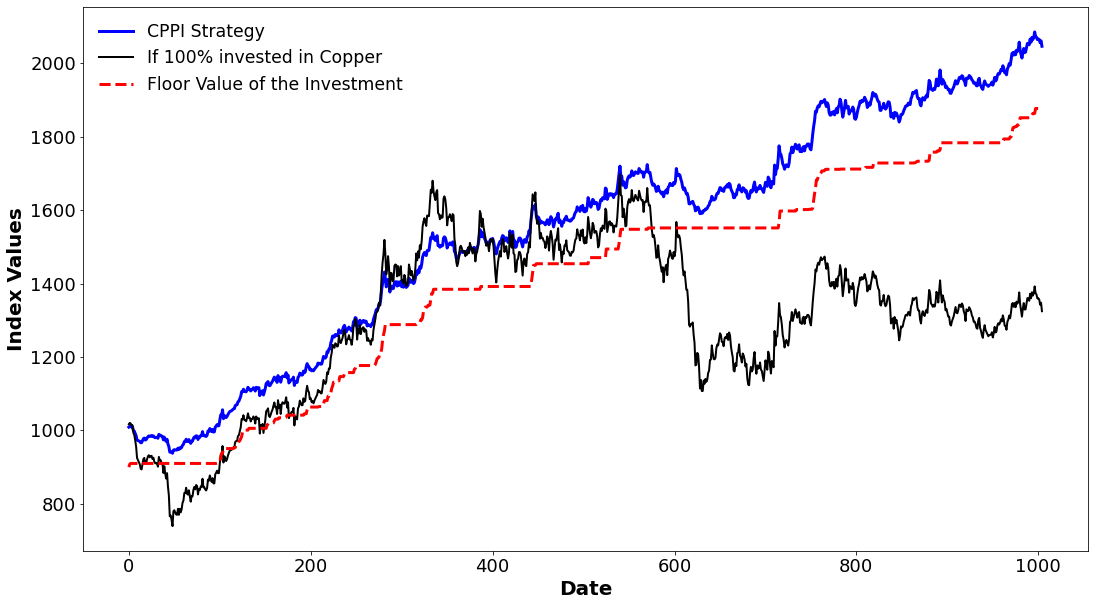

In [219]:

if __name__ == '__main__':
    main()

In [229]:
import numpy as np

def get_asset_parameters(ticker, start_date, end_date):
    """
    Télécharge les données historiques pour un actif et calcule les paramètres mu et sigma.

    Args:
    - ticker: Le ticker de l'actif (str)
    - start_date: La date de début pour les données historiques (str, format YYYY-MM-DD)
    - end_date: La date de fin pour les données historiques (str, format YYYY-MM-DD)

    Returns:
    - mu: Rendement moyen annuel (float)
    - sigma: Volatilité annuelle (float)
    """
    # Télécharger les données historiques
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Returns'] = data['Adj Close'].pct_change()
    data = data.dropna()

    # Calculer le rendement moyen annuel et la volatilité annuelle
    mu = data['Returns'].mean() * 252  # Rendement moyen annuel (252 jours de trading par an)
    sigma = data['Returns'].std() * np.sqrt(252)  # Volatilité annuelle

    return mu, sigma

def monte_carlo_simulation(mu, sigma, n_scenarios, n_years, steps_per_year):
    """
    Perform Monte Carlo simulation to generate future asset returns.
    
    Args:
    - mu: Expected annual return (float)
    - sigma: Annual volatility (float)
    - n_scenarios: Number of simulation scenarios (int)
    - n_years: Number of years for simulation (int)
    - steps_per_year: Number of time steps per year (int)
    
    Returns:
    - simulated_returns: Array of simulated asset returns (shape: (n_steps, n_scenarios))
    """
    n_assets = len(mu)
    n_steps = n_years * steps_per_year
    dt = 1 / steps_per_year

    simulated_returns = np.zeros((n_assets, n_steps, n_scenarios))

    for i in range(n_assets):
        returns_plus_1 = np.random.normal(loc=1 + mu[i] * dt, scale=sigma[i] * np.sqrt(dt), size=(n_steps, n_scenarios))
        returns_plus_1[0] = 1  # Set initial value to 1
        simulated_returns[i] = returns_plus_1.cumprod(axis=0)

    return simulated_returns

def evaluate_cppi_strategy(simulated_returns, start_value, floor, m):
    """
    Evaluate the CPPI strategy based on simulated returns.
    
    Args:
    - simulated_returns: Array of simulated asset returns (shape: (n_steps, n_scenarios))
    - start_value: Initial investment amount (float)
    - floor: Floor value for capital protection (float)
    - m: Leverage multiplier (float)
    
    Returns:
    - end_values: Array of final portfolio values for each scenario (shape: (n_scenarios,))
    """
    n_assets, n_steps, n_scenarios = simulated_returns.shape
    portfolio_values = np.zeros((n_steps, n_scenarios))
    portfolio_values[0] = start_value

    for t in range(1, n_steps):
        cushion = portfolio_values[t - 1] - floor
        risky_allocation = m * cushion
        safe_allocation = portfolio_values[t - 1] - risky_allocation

        risky_return = np.sum(simulated_returns[:, t, :] * (risky_allocation / np.sum(risky_allocation)), axis=0)
        safe_return = safe_allocation * (1 + 0.01 / steps_per_year)  # Assumed risk-free rate of 1% annually

        portfolio_values[t] = risky_return + safe_return

    return portfolio_values[-1]

def run_cppi_simulation(mu, sigma, n_scenarios, n_years, steps_per_year, start_value, floor, m):
    """
    Run Monte Carlo simulation for CPPI strategy evaluation.
    
    Args:
    - mu: Expected annual return (float)
    - sigma: Annual volatility (float)
    - n_scenarios: Number of simulation scenarios (int)
    - n_years: Number of years for simulation (int)
    - steps_per_year: Number of time steps per year (int)
    - start_value: Initial investment amount (float)
    - floor: Floor value for capital protection (float)
    - m: Leverage multiplier (float)
    
    Returns:
    - end_values: Array of final portfolio values for each scenario (shape: (n_scenarios,))
    """
    simulated_returns = monte_carlo_simulation(mu, sigma, n_scenarios, n_years, steps_per_year)
    end_values = evaluate_cppi_strategy(simulated_returns, start_value, floor, m)
    return end_values

# Paramètres de simulation
n_scenarios = 1000
n_years = 2
steps_per_year = 12
start_value = 10_000_000
floor = 0.90  # Exemple de floor (90% du capital protégé)
m_values = np.arange(0,5,0.5) # Valeurs de m à tester



# Définir les tickers des actifs
tickers = ['^GSPC', 'EWJ', 'GLD', 'CPER']

# Période pour les données historiques
start_date = '2020-01-01'
end_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Obtenir les paramètres pour chaque actif
mu_assets = []
sigma_assets = []
for ticker in tickers:
    mu, sigma = get_asset_parameters(ticker, start_date, end_date)
    mu_assets.append(mu)
    sigma_assets.append(sigma)

print("Tickers : ", tickers)
print("Volatilités annuelles:", sigma_assets) 
print("Rendements moyens annuels:", mu_assets)   # Volatilités pour chaque actif

# Exécuter des simulations pour chaque valeur de m et calculer les valeurs finales du portefeuille
for m in m_values:
    print(f"Running CPPI simulation with m={m} which represents the risk aversion in the CPPI strategy")
    portfolio_values = run_cppi_simulation(mu_assets, sigma_assets, n_scenarios, n_years, steps_per_year,
                                           start_value, floor, m)
    print(f"Average final portfolio value with m={m}: ${np.mean(portfolio_values):,.2f}")


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

c:\Users\maxim\anaconda3\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\maxim\anaconda3\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\maxim\anaconda3\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\maxim\anaconda3\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use 


Tickers :  ['^GSPC', 'EWJ', 'GLD', 'CPER']
Volatilités annuelles: [0.22186366393425636, 0.18885569419155113, 0.15489769781331575, 0.2411807997577637]
Rendements moyens annuels: [0.13400712376741417, 0.05988061978434503, 0.10448526603434143, 0.14412260803122304]
Running CPPI simulation with m=0.0 which represents the risk aversion in the CPPI strategy


TypeError: can't multiply sequence by non-int of type 'float'